**RiskPath – A Portfolio Forecasting Engine**

RiskPath is a lightweight portfolio forecasting engine that transforms risk tolerance into intuitive future return scenarios using Monte Carlo simulation and ETF-based asset allocation.

In [13]:
!pip install yfinance numpy pandas matplotlib scipy

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


In [15]:
# ===== USER INPUTS =====
risk = 8                 # 1 (very conservative) → 10 (very aggressive)
horizon = 5              # years
initial = 10000          # initial investment $
monthly = 300            # monthly contribution $
inflation_sensitive = True   # True or False


In [16]:
tickers = ["BIL","IEF","TLT","LQD","TIP","SPY","QQQ","EFA","EEM","GLD","VNQ"]


In [17]:
# =========================
# Asset Universe (ETF Pool)
# =========================
# BIL : 1–3 Month Treasury Bills → Cash proxy / near risk-free asset
# IEF : 7–10 Year Treasury → Intermediate-term government bonds (defensive core)
# TLT : 20+ Year Treasury → Long-term government bonds (high duration, crisis hedge)
# LQD : Investment Grade Corporate Bonds → High-quality corporate debt (stable income)
# TIP : TIPS → Inflation-protected bonds
# SPY : S&P 500 → U.S. large-cap equity market benchmark
# QQQ : Nasdaq-100 → Technology & growth stocks (higher volatility, higher growth)
# EFA : Developed Markets ex-US → International developed equity markets
# EEM : Emerging Markets → Emerging market equities (high growth, high risk)
# GLD : Gold → Inflation hedge & crisis protection asset
# VNQ : US REIT → U.S. real estate (income + inflation sensitivity)


In [18]:
prices = yf.download(tickers, start="2010-01-01", auto_adjust=True, progress=False)["Close"]
monthly_prices = prices.resample("M").last()
returns = monthly_prices.pct_change().dropna()

returns.head()


/tmp/ipython-input-1903957481.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = prices.resample("M").last()


Ticker,BIL,EEM,EFA,GLD,IEF,LQD,QQQ,SPY,TIP,TLT,VNQ
Date,,,,,,,,,,,
2010-02-28,-0.000218,0.017764,0.002668,0.032748,0.003318,0.005067,0.046038,0.031194,-0.013032,-0.003425,0.055831
2010-03-31,0.000000,0.081109,0.063854,-0.004386,-0.010568,0.006518,0.077109,0.060880,-0.000058,-0.020573,0.101868
2010-04-30,-0.000436,-0.001662,-0.028046,0.058834,0.016528,0.019079,0.022426,0.015470,0.025150,0.033217,0.071502
2010-05-31,0.000436,-0.093936,-0.111928,0.030513,0.029332,-0.013083,-0.073924,-0.079455,0.001917,0.051084,-0.053346
2010-06-30,0.000218,-0.013986,-0.020619,0.023553,0.030482,0.032785,-0.059757,-0.051741,0.012798,0.057978,-0.052123


In [19]:
def risk_to_weights(risk, inflation_sensitive=False):
    eq = 0.20 + (risk-1)*(0.90-0.20)/9
    defn = 1 - eq

    w = {}
    # Equity
    w["SPY"] = eq * 0.55
    w["QQQ"] = eq * 0.20
    w["VNQ"] = eq * 0.05
    intl = eq * 0.20
    w["EFA"] = intl * 0.6
    w["EEM"] = intl * 0.4

    # Defensive
    w["BIL"] = defn * 0.25
    w["IEF"] = defn * 0.35
    w["LQD"] = defn * 0.20
    w["TLT"] = defn * 0.20

    if inflation_sensitive:
        shift = min(0.10, w["IEF"])
        w["IEF"] -= shift
        w["TIP"] = shift
    else:
        w["TIP"] = 0

    # Normalize
    total = sum(w.values())
    for k in w:
        w[k] /= total
    return w


weights = risk_to_weights(risk, inflation_sensitive)
w = pd.Series(weights).reindex(returns.columns).fillna(0)

print("Recommended Allocation (%):")
display((w*100).round(2))


Recommended Allocation (%):


,0
Ticker,
BIL,6.39
EEM,5.96
EFA,8.93
GLD,0.00
IEF,0.00
LQD,5.11
QQQ,14.89
SPY,40.94
TIP,8.94


In [20]:
portfolio_returns = returns @ w.values

def simulate_wealth(returns, initial, monthly):
    wealth = []
    v = initial
    for r in returns:
        v = v*(1+r) + monthly
        wealth.append(v)
    return pd.Series(wealth, index=returns.index)

wealth = simulate_wealth(portfolio_returns, initial, monthly)

ann_ret = (1 + portfolio_returns.mean())**12 - 1
ann_vol = portfolio_returns.std() * np.sqrt(12)
max_dd = (wealth / wealth.cummax() - 1).min()

print("Annual Return:", round(ann_ret*100,2),"%")
print("Annual Volatility:", round(ann_vol*100,2),"%")
print("Max Drawdown:", round(max_dd*100,2),"%")


Annual Return: 11.61 %
Annual Volatility: 11.13 %
Max Drawdown: -21.97 %


In [21]:
def bootstrap(returns, initial, monthly, years, n=2000):
    months = years * 12
    r = returns.values
    end_vals = []
    for _ in range(n):
        draw = np.random.choice(r, size=months, replace=True)
        v = initial
        for rr in draw:
            v = v*(1+rr) + monthly
        end_vals.append(v)
    return np.percentile(end_vals,[5,50,95])

p5, p50, p95 = bootstrap(portfolio_returns, initial, monthly, horizon)

print(f"After {horizon} years:")
print(f"Worst 5% case : ${p5:,.0f}")
print(f"Median case   : ${p50:,.0f}")
print(f"Best 5% case  : ${p95:,.0f}")


After 5 years:
Worst 5% case : $30,086
Median case   : $40,350
Best 5% case  : $55,493


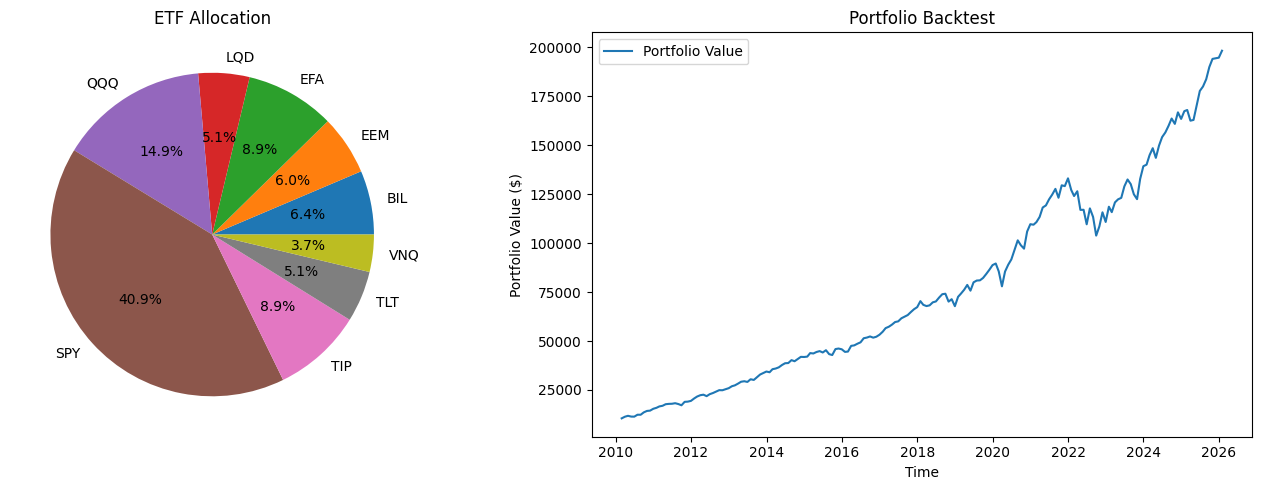

In [22]:
plt.figure(figsize=(14,5))

# Allocation Pie
plt.subplot(1,2,1)
alloc = w[w>0]
plt.pie(alloc, labels=alloc.index, autopct='%1.1f%%')
plt.title("ETF Allocation")

# Wealth curve
plt.subplot(1,2,2)
plt.plot(wealth, label="Portfolio Value")
plt.title("Portfolio Backtest")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.legend()

plt.tight_layout()
plt.show()


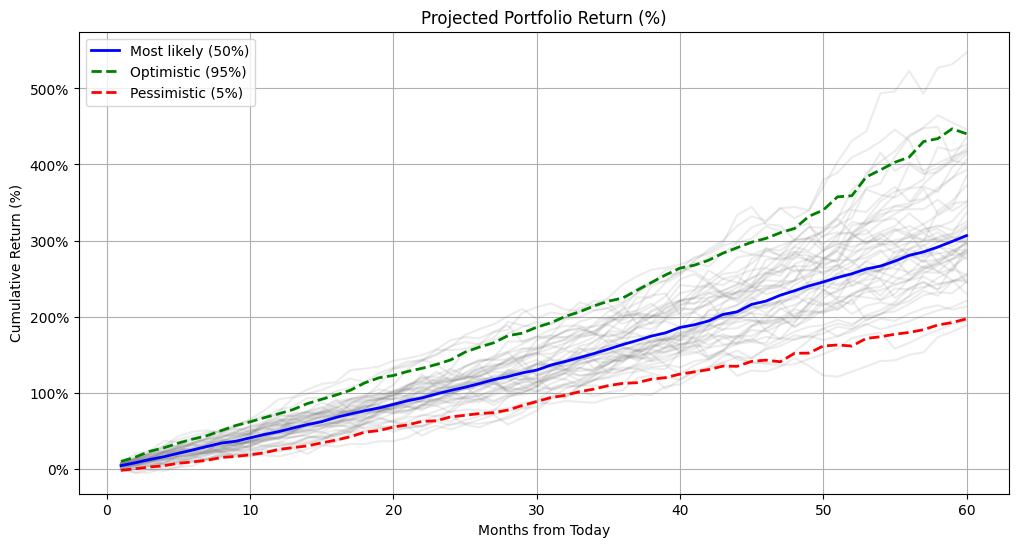

In [23]:
# =========================
# Future Return Forecast (Monte Carlo, in %)
# =========================

def simulate_future_return_paths(returns, initial, monthly, years, n_paths=300):
    months = years * 12
    r = returns.values

    paths = []
    for _ in range(n_paths):
        draw = np.random.choice(r, size=months, replace=True)
        v = initial
        wealth_path = []
        for rr in draw:
            v = v * (1 + rr) + monthly
            wealth_path.append(v)

        wealth_path = np.array(wealth_path)
        # Convert to cumulative return %
        return_path = (wealth_path - initial) / initial
        paths.append(return_path)

    return np.array(paths)

# Generate future simulations (percentage returns)
return_paths = simulate_future_return_paths(
    portfolio_returns,
    initial,
    monthly,
    horizon,
    n_paths=300
)

# Percentile paths
p5_path  = np.percentile(return_paths, 5, axis=0)
p50_path = np.percentile(return_paths, 50, axis=0)
p95_path = np.percentile(return_paths, 95, axis=0)

# Time axis
months = np.arange(1, horizon*12 + 1)

# =========================
# Plot Forecast in % Return
# =========================

plt.figure(figsize=(12,6))

# Plot many faint future scenarios
for i in range(50):
    plt.plot(months, return_paths[i], color="gray", alpha=0.15)

# Main forecast lines
plt.plot(months, p50_path, color="blue", linewidth=2, label="Most likely (50%)")
plt.plot(months, p95_path, color="green", linewidth=2, linestyle="--", label="Optimistic (95%)")
plt.plot(months, p5_path,  color="red", linewidth=2, linestyle="--", label="Pessimistic (5%)")

plt.title("Projected Portfolio Return (%)")
plt.xlabel("Months from Today")
plt.ylabel("Cumulative Return (%)")
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x*100:.0f}%")

plt.legend()
plt.grid(True)
plt.show()
